In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chitwanmanchanda/fraudulent-transactions-data")

print("Path to dataset files:", path)

100%|██████████| 178M/178M [00:03<00:00, 55.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/chitwanmanchanda/fraudulent-transactions-data/versions/1


In [ ]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# Explainability
from lime.lime_tabular import LimeTabularExplainer


In [ ]:


df = pd.read_csv(path + "/Fraud.csv")
df.shape

(6362620, 11)

In [ ]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
# Explore the dataset further
print("Dataset Overview:")
print(df.info())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


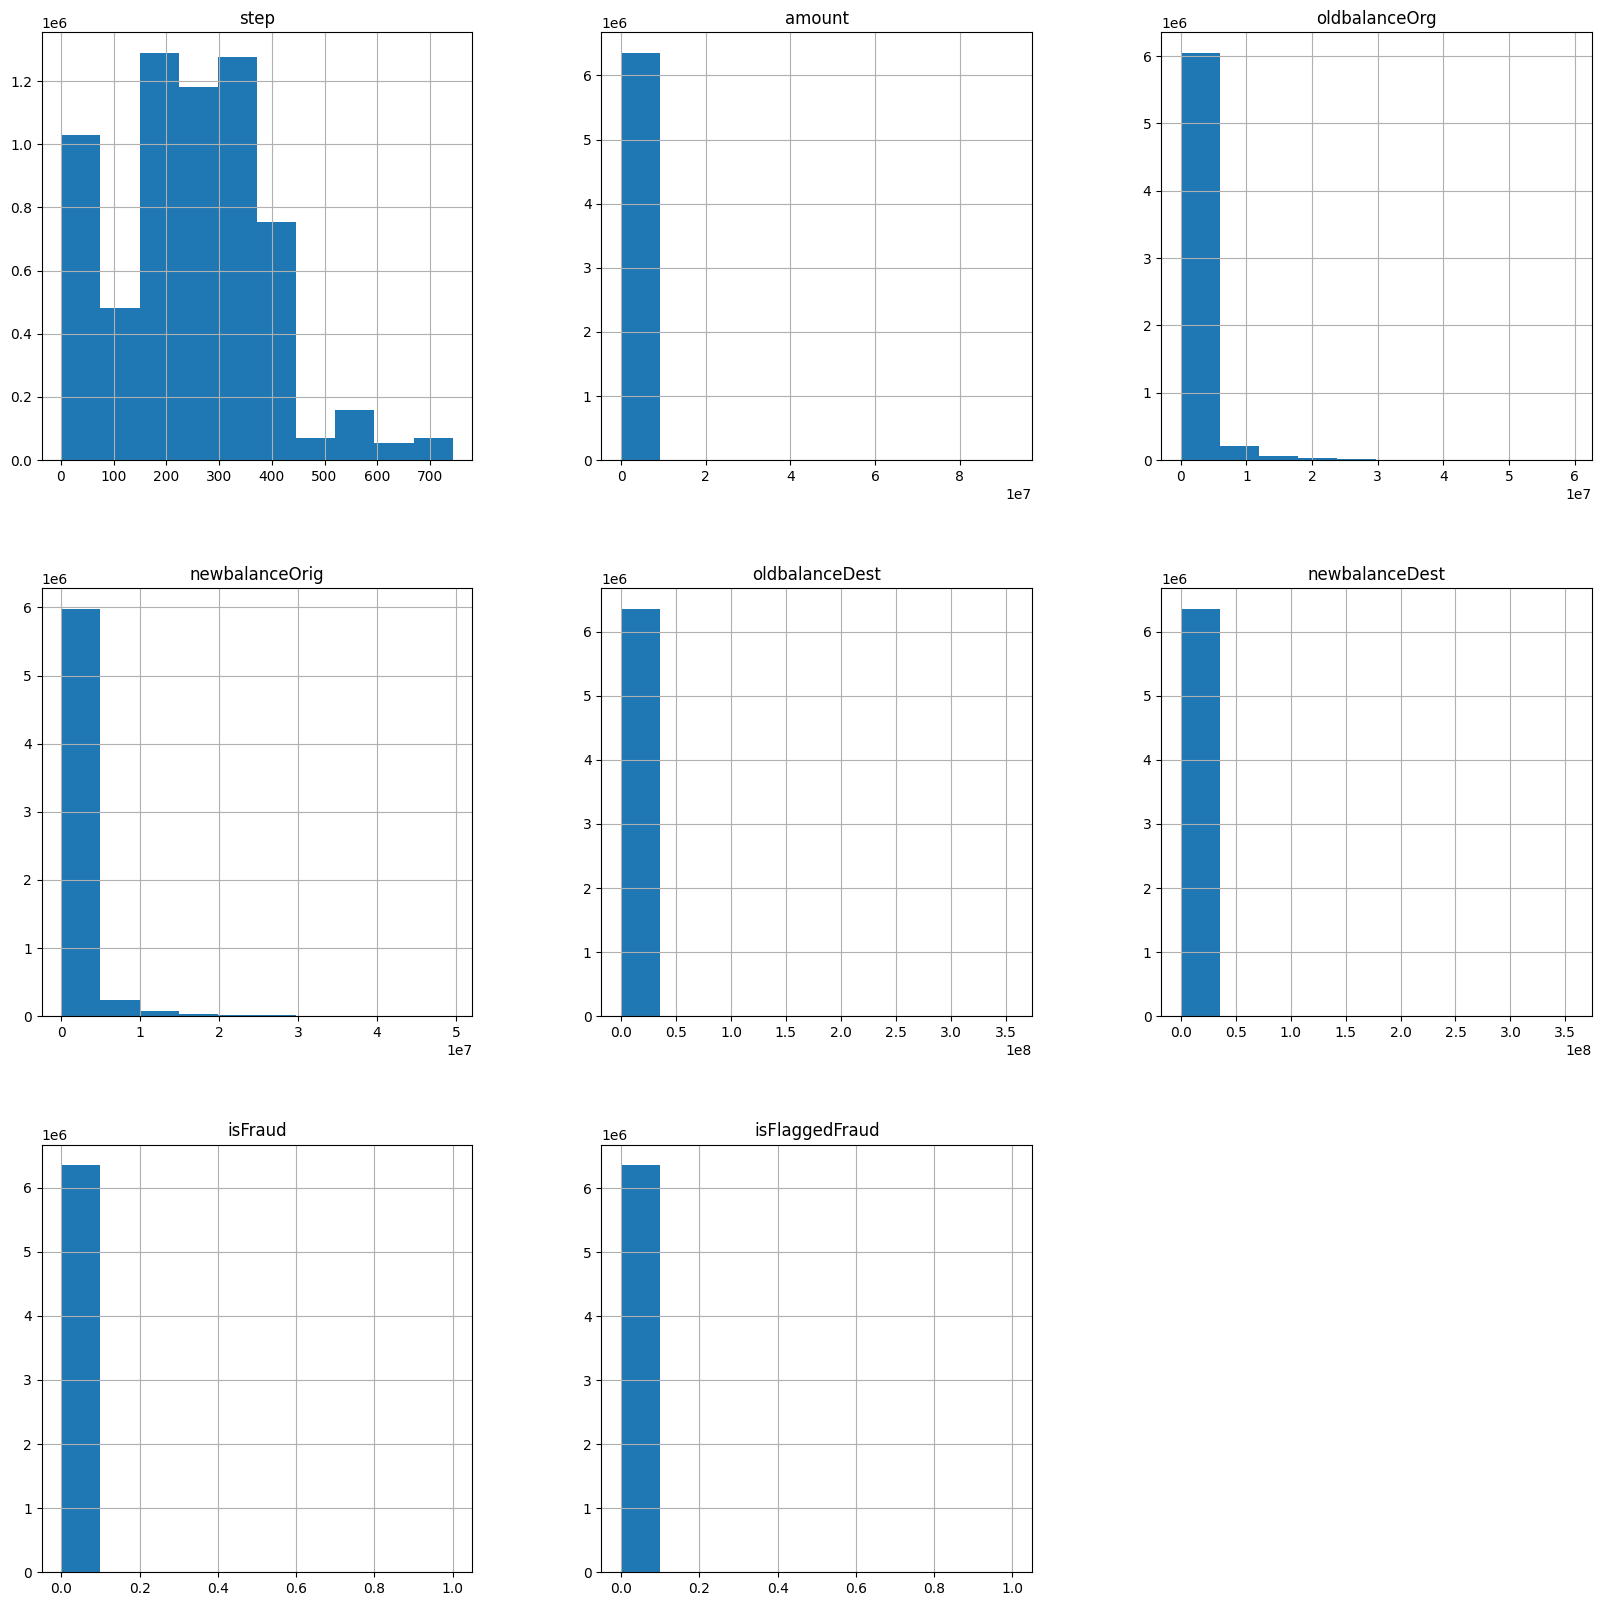

In [ ]:
df.hist(figsize=(20,20))
plt.show()

In [ ]:
df.shape
positive = df[df.isFraud == 1]
negative = df[df.isFraud == 0]
print(f"Fraudulent Transaction Percentage: {len(positive)/len(df)*100}")
print(f"Legitimate Transaction Percentage: {len(negative)/len(df)*100}")

Fraudulent Transaction Percentage: 0.12908204481801522
Legitimate Transaction Percentage: 99.87091795518198


In [ ]:
# Data Preprocessing

# a. One-Hot Encode Categorical Variables (Already Done)
categorical_features = ['type']  # Add other categorical columns if any
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# b. Identify and Drop Non-Numeric Columns
non_numeric_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
print("Non-numeric columns to drop:", non_numeric_cols)

# Drop the non-numeric columns
df_encoded.drop(columns=non_numeric_cols, inplace=True)
print("Columns after dropping non-numeric columns:", df_encoded.columns.tolist())

# c. Check for Missing Values After Encoding and Dropping
print("Missing values per column after encoding and dropping non-numeric columns:")
print(df_encoded.isnull().sum())

# d. Feature Scaling


X = df_encoded.drop(['isFraud'], axis=1)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


Non-numeric columns to drop: ['nameOrig', 'nameDest']
Columns after dropping non-numeric columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
Missing values per column after encoding and dropping non-numeric columns:
step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64


In [ ]:
# Identify columns with object dtype
non_numeric_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: []


In [ ]:
# Splitting the data


# Separate legitimate and fraudulent transactions
legit_transactions = X_scaled[df['isFraud'] == 0]
fraud_transactions = X_scaled[df['isFraud'] == 1]

print(f"Number of legitimate transactions: {legit_transactions.shape[0]}")
print(f"Number of fraudulent transactions: {fraud_transactions.shape[0]}")

# Train-Test Split
X_train, X_val = train_test_split(legit_transactions, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Number of legitimate transactions: 6354407
Number of fraudulent transactions: 8213
Training set shape: (5083525, 11)
Validation set shape: (1270882, 11)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,027 (27.45 KB)

 Trainable params: 7,027 (27.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 0.0250 - val_loss: 6.7837e-04
Epoch 2/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - loss: 0.0012 - val_loss: 2.2852e-04
Epoch 3/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 8.1900e-04 - val_loss: 0.0010
Epoch 4/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 6.8270e-04 - val_loss: 2.3620e-04
Epoch 5/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 6.7281e-04 - val_loss: 6.7959e-04
Epoch 6/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 5.3946e-04 - val_loss: 1.9300e-04
Epoch 7/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 4.4604e-04 - val_loss: 4.5004e-04
Epoch 8/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - loss: 4.5347e-04 - val_loss: 3.3005e-04
Epoch 9/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - loss: 2.9637e-04 - val_loss: 6.6808e-05
Epoch 10/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - loss: 4.8199e-04 - val_loss: 0.0016


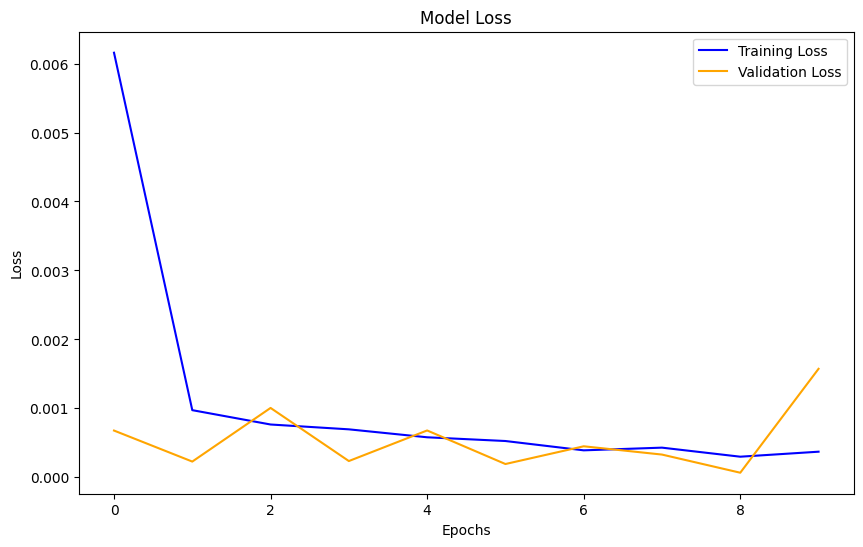

198832/198832 ━━━━━━━━━━━━━━━━━━━━ 317s 2ms/step


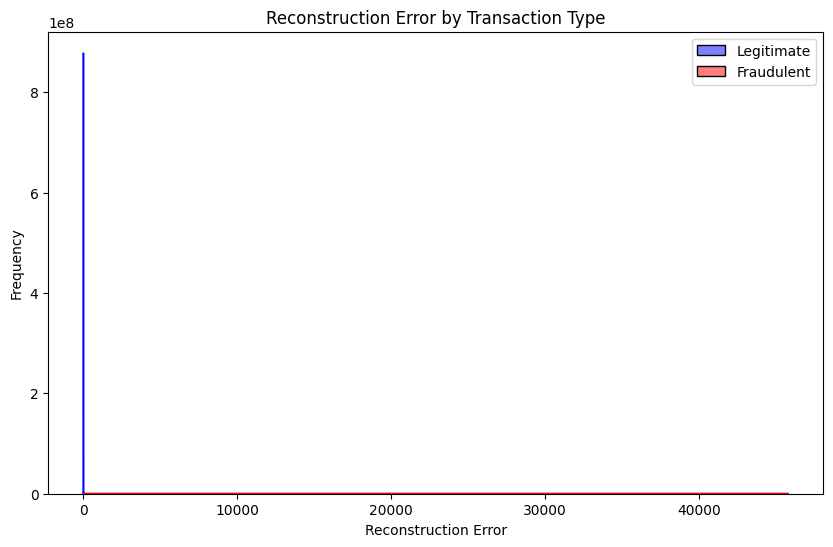

Reconstruction error threshold: 0.00014429343553252195
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   6354407
           1       0.02      0.73      0.04      8213

    accuracy                           0.95   6362620
   macro avg       0.51      0.84      0.51   6362620
weighted avg       1.00      0.95      0.97   6362620



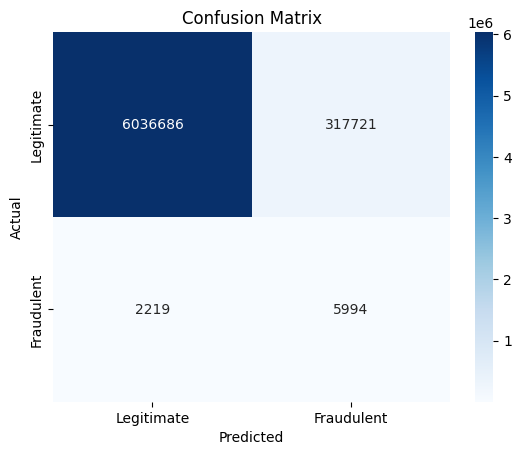

In [ ]:


def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    encoded = layers.Dense(16, activation='relu')(encoded)
    bottleneck = layers.Dense(8, activation='relu')(encoded)
    decoded = layers.Dense(16, activation='relu')(bottleneck)
    decoded = layers.Dense(32, activation='relu')(decoded)
    decoded = layers.Dense(64, activation='relu')(decoded)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded)
    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

autoencoder = build_autoencoder(X_train.shape[1])
autoencoder.summary()

# Training the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

# Plotting training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Computing reconstruction errors
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
df_encoded['reconstruction_error'] = mse
df_encoded['isFraud'] = df['isFraud'].values

# Visualizing reconstruction errors
plt.figure(figsize=(10,6))
sns.histplot(df_encoded[df_encoded['isFraud'] == 0]['reconstruction_error'], bins=50, color='blue', label='Legitimate', kde=True)
sns.histplot(df_encoded[df_encoded['isFraud'] == 1]['reconstruction_error'], bins=50, color='red', label='Fraudulent', kde=True)
plt.title('Reconstruction Error by Transaction Type')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Determining threshold
threshold = np.percentile(mse[df['isFraud'] == 0], 95)
print(f"Reconstruction error threshold: {threshold}")

# Classifying transactions
df_encoded['predicted_isFraud'] = df_encoded['reconstruction_error'] > threshold

# Evaluating the performance


y_true = df_encoded['isFraud']
y_pred = df_encoded['predicted_isFraud'].astype(int)

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## RNN TRAINING


In [ ]:
# Extract bottleneck features from the autoencoder
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_3').output)
encoded_features = encoder.predict(X_scaled)

print("Shape of encoded features:", encoded_features.shape)


198832/198832 ━━━━━━━━━━━━━━━━━━━━ 308s 2ms/step
Shape of encoded features: (6362620, 8)


In [ ]:


# Separate legitimate and fraud transactions based on encoded features
encoded_legit = encoded_features[df['isFraud'] == 0]
encoded_fraud = encoded_features[df['isFraud'] == 1]

X_combined = np.vstack((encoded_legit, encoded_fraud))
y_combined = np.array([0]*len(encoded_legit) + [1]*len(encoded_fraud))

print("Legitimate samples:", len(encoded_legit))
print("Fraudulent samples:", len(encoded_fraud))
print("X_combined shape:", X_combined.shape)
print("y_combined shape:", y_combined.shape)

# Define sequence length
sequence_length = 10

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2,
                                                  random_state=42, stratify=y_combined)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Create Timeseries Generators for training and validation sets
train_gen = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=256)
val_gen = TimeseriesGenerator(X_val, y_val, length=sequence_length, batch_size=256)

# Check a batch shape for sanity
x_batch, y_batch = train_gen[0]
print("x_batch shape (train):", x_batch.shape)  # Should be (batch_size, sequence_length, feature_dim)
print("y_batch shape (train):", y_batch.shape)  # Should be (batch_size,)

# Build an LSTM model to classify sequences as fraud or not
def build_lstm_model(input_shape):
    model = models.Sequential([
        layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (sequence_length, encoded_features.shape[1])
lstm_model = build_lstm_model(input_shape)
lstm_model.summary()

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM
history = lstm_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    callbacks=[early_stop],
    verbose=1
)

# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the validation data
y_pred_proba = lstm_model.predict(val_gen)
y_pred = (y_pred_proba > 0.5).astype(int)

# Collect the true labels from val_gen
y_true_list = []
for i in range(len(val_gen)):
    _, y_true_batch = val_gen[i]
    y_true_list.append(y_true_batch)
y_true = np.concatenate(y_true_list)

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Model: "sequential_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 10, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤

In [ ]:
# Extract a batch of sequences for SHAP interpretation
x_batch, y_batch = val_gen[0]  # First batch from validation generator
print(f"x_batch shape: {x_batch.shape}")  # (batch_size, sequence_length, features)


x_batch shape: (256, 10, 8)


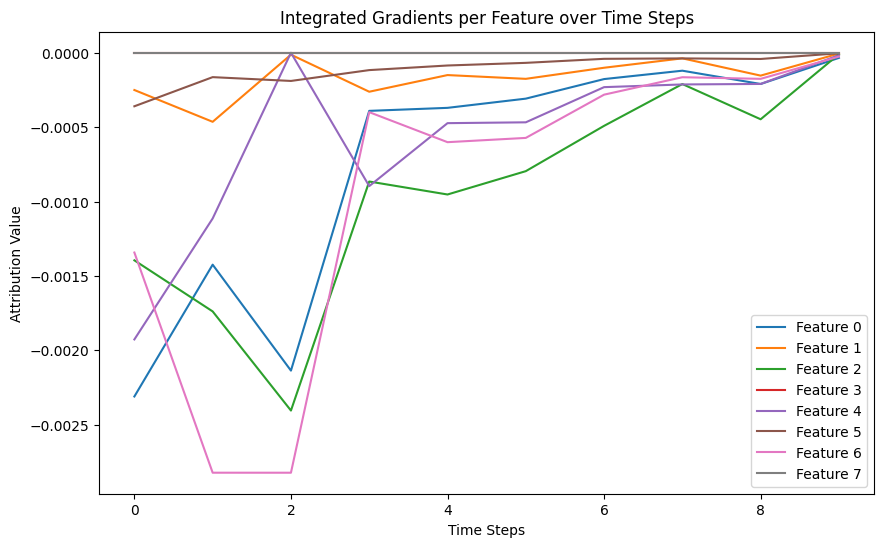

In [ ]:


# Define Integrated Gradients class
class IntegratedGradients:
    def __init__(self, model):
        self.model = model

    def compute_gradients(self, inputs, baseline=None, steps=50):
        # Ensure inputs and baseline are tensors
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        if baseline is None:
            baseline = tf.zeros_like(inputs)  # Default baseline (zeros)
        else:
            baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

        # Generate interpolated inputs
        interpolated_inputs = tf.linspace(baseline, inputs, steps)
        interpolated_inputs = tf.reshape(interpolated_inputs, (steps,) + inputs.shape)

        # Compute gradients
        with tf.GradientTape() as tape:
            tape.watch(interpolated_inputs)
            predictions = self.model(interpolated_inputs)

        grads = tape.gradient(predictions, interpolated_inputs)

        # Average gradients and compute integrated gradients
        avg_grads = tf.reduce_mean(grads, axis=0)
        integrated_gradients = (inputs - baseline) * avg_grads
        return integrated_gradients.numpy()  # Convert to NumPy for visualization

# Instantiate IG for the LSTM model
ig = IntegratedGradients(lstm_model)

# Select an input sequence and ensure it's a tensor
input_sequence = tf.convert_to_tensor(x_batch[0], dtype=tf.float32)

# Compute Integrated Gradients
integrated_gradients = ig.compute_gradients(input_sequence)

# Visualize Results
plt.figure(figsize=(10, 6))
for feature_idx in range(input_sequence.shape[-1]):  # Iterate over features
    plt.plot(integrated_gradients[:, feature_idx], label=f'Feature {feature_idx}')
plt.title("Integrated Gradients per Feature over Time Steps")
plt.xlabel("Time Steps")
plt.ylabel("Attribution Value")
plt.legend()
plt.show()


In [ ]:
def predict_fn(data):
    # Reshape input back to 3D for the LSTM model
    reshaped_data = data.reshape(data.shape[0], sequence_length, -1)
    # Get probabilities for class 1 (Fraudulent) and class 0 (Legitimate)
    probabilities = lstm_model.predict(reshaped_data)
    return np.hstack([1 - probabilities, probabilities])  # Add probabilities for both classes


In [ ]:


# Flatten the validation data
flat_x_batch = x_batch.reshape(x_batch.shape[0], -1)

# Instantiate the LIME explainer
explainer = LimeTabularExplainer(
    flat_x_batch,
    mode='classification',
    feature_names=[f"T{t}_F{f}" for t in range(sequence_length) for f in range(x_batch.shape[2])],
    class_names=['Legitimate', 'Fraudulent'],
    discretize_continuous=True
)

# Explain the first sequence
instance_idx = 0  # Choose which sequence to explain
explanation = explainer.explain_instance(flat_x_batch[instance_idx], predict_fn, num_features=10)

# Visualize the explanation
explanation.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:


smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
print("X_train shape:", X_train.shape)
print("Total elements in X_train:", X_train.size)


X_train shape: (5090096, 8)
Total elements in X_train: 40720768


In [ ]:


# Parameters
sequence_length = 10  # Length of each sequence
num_features = 8      # Number of features in your data

# Trim X_train to make it divisible by sequence_length
num_samples = X_train.shape[0] // sequence_length * sequence_length  # Find max divisible size
X_train_trimmed = X_train[:num_samples]  # Trim the excess rows
y_train_trimmed = y_train[:num_samples]  # Ensure labels match

# Reshape X_train into (batch_size, sequence_length, num_features)
X_train_reshaped = X_train_trimmed.reshape(-1, sequence_length, num_features)
y_train_reshaped = y_train_trimmed[::sequence_length]  # Use one label per sequence

# Repeat the same process for X_val
num_samples_val = X_val.shape[0] // sequence_length * sequence_length
X_val_trimmed = X_val[:num_samples_val]
y_val_trimmed = y_val[:num_samples_val]

X_val_reshaped = X_val_trimmed.reshape(-1, sequence_length, num_features)
y_val_reshaped = y_val_trimmed[::sequence_length]

# Print shapes
print("Reshaped X_train shape:", X_train_reshaped.shape)  # (batch_size, sequence_length, num_features)
print("Reshaped y_train shape:", y_train_reshaped.shape)  # (batch_size,)
print("Reshaped X_val shape:", X_val_reshaped.shape)
print("Reshaped y_val shape:", y_val_reshaped.shape)


Reshaped X_train shape: (509009, 10, 8)
Reshaped y_train shape: (509009,)
Reshaped X_val shape: (127252, 10, 8)
Reshaped y_val shape: (127252,)


In [ ]:
# Ensure data is in the correct format
X_train_reshaped = X_train_reshaped.astype('float32')
y_train_reshaped = y_train_reshaped.astype('int')
X_val_reshaped = X_val_reshaped.astype('float32')
y_val_reshaped = y_val_reshaped.astype('int')


In [ ]:




# Clear TensorFlow session to reset graphs and variables
tf.keras.backend.clear_session()






In [ ]:

# Rebuild the LSTM model


lstm_model = Sequential([
    LSTM(64, input_shape=(sequence_length, num_features), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = lstm_model.fit(
    X_train_reshaped, y_train_reshaped,
    validation_data=(X_val_reshaped, y_val_reshaped),
    class_weight=class_weights,
    epochs=10,
    batch_size=256
)


Epoch 1/10
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 110s 51ms/step - accuracy: 0.9967 - loss: 0.2506 - val_accuracy: 0.9907 - val_loss: 0.0507
Epoch 2/10
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 141s 51ms/step - accuracy: 0.9932 - loss: 0.1646 - val_accuracy: 0.9983 - val_loss: 0.0404
Epoch 3/10
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 106s 53ms/step - accuracy: 0.9926 - loss: 0.1567 - val_accuracy: 0.9987 - val_loss: 0.0443
Epoch 4/10
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 105s 53ms/step - accuracy: 0.9950 - loss: 0.1533 - val_accuracy: 0.9991 - val_loss: 0.0429
Epoch 5/10
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 141s 52ms/step - accuracy: 0.9952 - loss: 0.1594 - val_accuracy: 0.9803 - val_loss: 0.0699
Epoch 6/10
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 103s 52ms/step - accuracy: 0.9939 - loss: 0.1399 - val_accuracy: 0.9980 - val_loss: 0.0270
Epoch 7/10
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 140s 51ms/step - accuracy: 0.9951 - loss: 0.1432 - val_accuracy: 0.9974 - val_loss: 0.0259
Epoch 8/10
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 142s 51ms/step - accuracy: 

3977/3977 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    127105
  Fraudulent       0.13      0.61      0.21       147

    accuracy                           0.99    127252
   macro avg       0.56      0.80      0.61    127252
weighted avg       1.00      0.99      1.00    127252



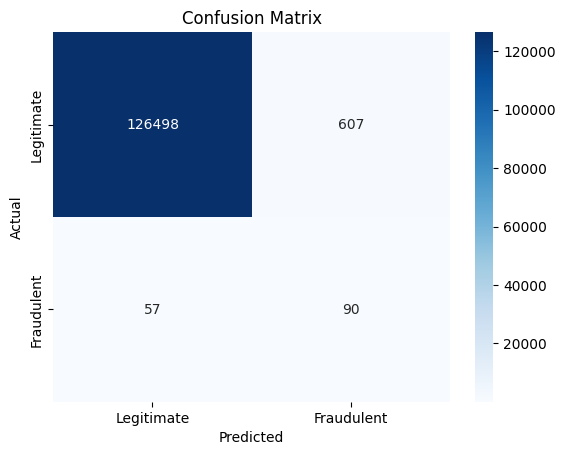

ROC-AUC: 0.9426


In [ ]:


# Predict on validation data
y_val_pred_proba = lstm_model.predict(X_val_reshaped).flatten()
y_val_pred = (y_val_pred_proba > 0.5).astype(int)  # Apply threshold

# Classification report
print(classification_report(y_val_reshaped, y_val_pred, target_names=['Legitimate', 'Fraudulent']))

# Confusion matrix
cm = confusion_matrix(y_val_reshaped, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_val_reshaped, y_val_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")



157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


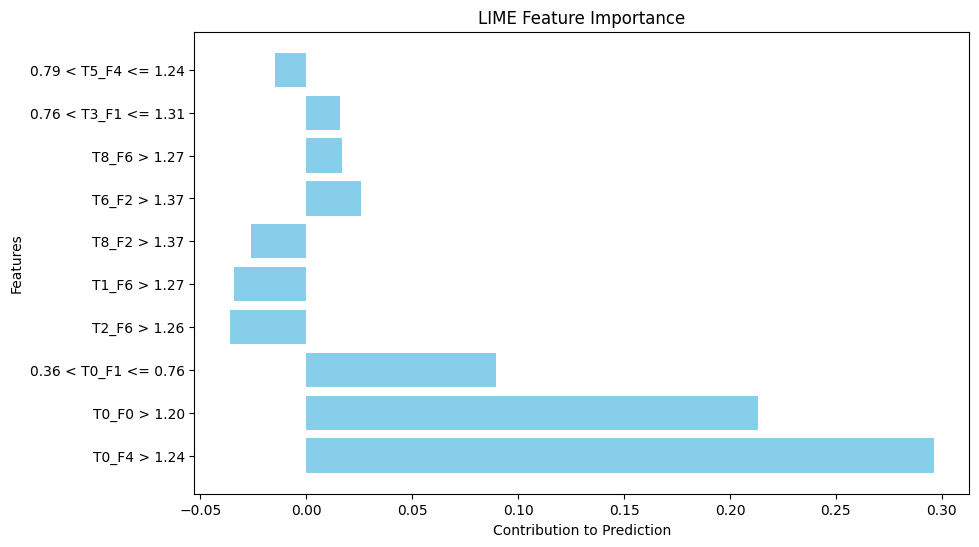

In [ ]:


# Flatten the validation data
flat_X_val = X_val_reshaped.reshape(X_val_reshaped.shape[0], -1)  # (batch_size, sequence_length * features)

# Define a prediction function for LIME
def predict_fn(data):
    reshaped_data = data.reshape(data.shape[0], sequence_length, num_features)  # Reshape back to 3D
    return np.hstack([1 - lstm_model.predict(reshaped_data), lstm_model.predict(reshaped_data)])  # Probabilities for both classes

# Create LIME explainer
explainer = LimeTabularExplainer(
    flat_X_val,
    mode='classification',
    feature_names=[f"T{t}_F{f}" for t in range(sequence_length) for f in range(num_features)],
    class_names=['Legitimate', 'Fraudulent'],
    discretize_continuous=True
)

# Explain a specific instance
instance_idx = 0  # First sequence
explanation = explainer.explain_instance(flat_X_val[instance_idx], predict_fn, num_features=10)

# Visualize explanation
explanation.show_in_notebook()

# Optional: Bar chart visualization
lime_importances = explanation.as_list()
features, weights = zip(*lime_importances)

plt.figure(figsize=(10, 6))
plt.barh(features, weights, color='skyblue')
plt.title("LIME Feature Importance")
plt.xlabel("Contribution to Prediction")
plt.ylabel("Features")
plt.show()
